### DATA PREPROCESSING

In [154]:
%reload_ext autoreload
%autoreload 2

# imports
import os
import ast
import math
import json
import requests
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import ipywidgets as widgets
import plotly.express as px

import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf


from scipy import stats
from datetime import datetime as dt
from ipywidgets import interact, interactive, fixed, interact_manual

from IPython.display import HTML
from statsmodels.stats.multicomp import pairwise_tukeyhsd

sns.set_theme()

In [155]:
import helpers

# Data Loading , the imprt_movies_data function load and preprocess the data
movies,characters = helpers.import_movies_data("./data/")

movies.shape

/Users/zhouyanling/Downloads/CS-401/ada/ada-2023-project-zalix/helpers.py:73: UserWarning:

The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.



(14369, 13)

### GENRE

In the realm of movies, genres play a crucial role in defining the stylistic and thematic elements that shape a film's identity. Unlike strict boundaries, many movies embrace a blend of genres, creating a rich tapestry of storytelling that transcends traditional categorizations. From action-packed adventures with a touch of romance to thought-provoking science fiction infused with elements of comedy, the interplay of multiple genres adds layers of complexity and intrigue to cinematic experiences. Whether it's a thrilling action-comedy, a romantic fantasy epic, or a crime drama with elements of mystery, the fusion of genres allows filmmakers to craft narratives that appeal to a diverse audience, offering a dynamic and ever-evolving landscape within the world of cinema.

In our evaluation of cinematic quality, the role of genres in influencing ratings emerges as a noteworthy consideration. The objectives of this analysis encompass the exploration of various research questions:

- Identification of the top 10 most prolific genres in the history of cinema.
- Evaluation of the proportion of exemplary films within the aforementioned 10 most prolific genres, defined here as those with a rating of 7 or higher.
- Examination of the intersection between genres and the temporal variable, aiming to identify "golden eras" marked by periods with the highest number of highly-rated films within a specific genre. This will be accomplished through the visualization of highly-rated movie counts per decade.
- Scrutiny of genre combinations to discern noteworthy amalgamations during specific time periods. This aspect of the analysis will involve the generation of a bar chart illustrating the ratio of highly-rated movies relative to each decade.

In [156]:
#genres
genres = movies["movie_genres"].str.split(",", expand=True).stack().value_counts()
print(genres.shape)
print(genres)


(784,)
 "/m/07s9rl0": "Drama"                    3486
 "/m/01z4y": "Comedy"                     1999
{"/m/01jfsb": "Thriller"                  1566
 "/m/01z4y": "Comedy"}                    1387
 "/m/01g6gs": "Black-and-white"}          1348
                                          ... 
{"/m/03jp5h0": "Archaeology"                 1
 "/m/0fx2s": "Tragedy"}                      1
{"/m/0hj3n11": "Environmental Science"       1
{"/m/01lrrt": "Melodrama"}                   1
{"/m/01lmb_": "Sword and Sandal"             1
Name: count, Length: 784, dtype: int64


In [157]:
#extract the main genre
def extract_genres(row):
    try:
        genres_dict = json.loads(row)
        return list(genres_dict.values()) if genres_dict else ['NaN']
    except json.JSONDecodeError:
        return ['NaN']

# Apply the function to create a new 'genre' column
movies['genre'] = movies['movie_genres'].apply(extract_genres)
genre=movies['genre'].explode().copy()
genre=genre[genre!='NaN']
genre=genre.value_counts()
#find the unique genres
unique_genres = genre.index
print(unique_genres)

Index(['Drama', 'Comedy', 'Black-and-white', 'Romance Film', 'Thriller',
       'Action', 'Crime Fiction', 'Short Film', 'Indie', 'Adventure',
       ...
       'Historical Documentaries', 'Race movie', 'Science fiction Western',
       'Kitchen sink realism', 'Filipino', 'Sci-Fi Thriller',
       'Political Documetary', 'Nuclear warfare', 'Space opera',
       'Revisionist Fairy Tale'],
      dtype='object', name='genre', length=323)


In [158]:
# plot the number of movies per genre using plotly
fig = px.bar(genre, x=genre.index, y=genre.values, color=genre.values, color_continuous_scale=["blue", "blue"], width=1000)
fig.update_layout(
    xaxis_title="Figure 1.1: Number of Movies per Genre",
    yaxis_title="Number of movies",
    title="Genres",
    showlegend=False
)
fig.write_html("1-1.html")
fig.show()

Upon examination of the aforementioned graph, it becomes evident that there are over 700 genres, with a considerable portion having a minimal number of movies, rendering them inconsequential for our analytical purposes. Consequently, we have elected to narrow our focus to the top ten genres, as they not only serve as more representative subsets but also encapsulate the majority of films within our dataset.

In [159]:
# give the top 10 genres that has the largerst number of movies and store them in genre_main
genre_main = genre[:10]
print(genre_main.index)

Index(['Drama', 'Comedy', 'Black-and-white', 'Romance Film', 'Thriller',
       'Action', 'Crime Fiction', 'Short Film', 'Indie', 'Adventure'],
      dtype='object', name='genre')


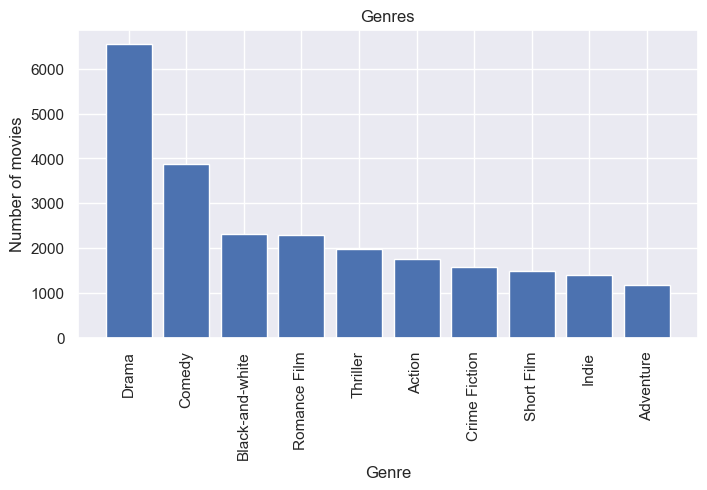

In [160]:
#plot the top 10 genres
plt.figure(figsize=(8, 4))
plt.bar(genre_main.index, genre_main.values)
plt.xticks(rotation=90)
plt.title("Genres")
plt.xlabel("Genre")
plt.ylabel("Number of movies")
plt.show()


In [161]:
#filter the movies that have the genres in genre_main, not necessarily the first genre
movies_main = movies[movies['genre'].apply(lambda x: any(item for item in x if item in genre_main.index))].copy()
print(movies_main.shape)
movies_main.head()


(12463, 14)


,wikipedia_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,year_released,tconst,averageRating,numVotes,genre
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,tt0228333,4.9,56928.0,"[Thriller, Science Fiction, Horror, Adventure,..."
2,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913,tt0002894,6.8,17.0,"[Short Film, Silent film, Indie, Black-and-whi..."
3,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938,tt0029852,6.8,2268.0,"[Musical, Comedy, Black-and-white]"
5,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",1989,tt0097499,7.5,31208.0,"[Costume drama, War film, Epic, Period piece, ..."
6,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",1964,tt0058331,7.8,181829.0,"[Children's/Family, Musical, Fantasy, Comedy, ..."


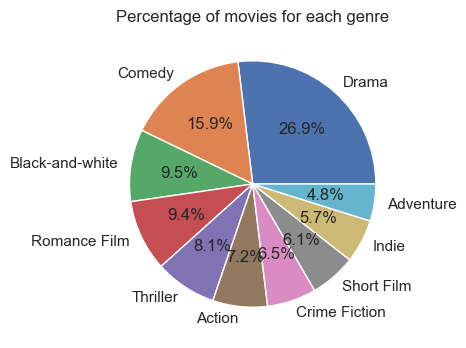

In [162]:
# plot a pie chart for the top 10 genres in the decade 2000-2010 which shows the percentage of the number of movies for each genre in genre_main
movie_genre=movies_main['genre'].explode().value_counts()[genre_main.index]
plt.figure(figsize=(8, 4))
plt.pie(movie_genre.values, labels=movie_genre.index, autopct='%1.1f%%')
plt.title("Percentage of movies for each genre")
plt.show()

Given that our criterion for categorizing "good" movies hinges on those with a rating surpassing 7, we proceed to implement a filtering mechanism. This entails narrowing our focus exclusively to movies meeting this specific high-rating threshold. By concentrating on this subset of films, we aim to glean more targeted insights into the characteristics and trends associated with movies that align with the established criteria for excellence.

(10,)
Index(['Drama', 'Comedy', 'Black-and-white', 'Romance Film', 'Thriller',
       'Action', 'Crime Fiction', 'Short Film', 'Indie', 'Adventure'],
      dtype='object', name='genre')


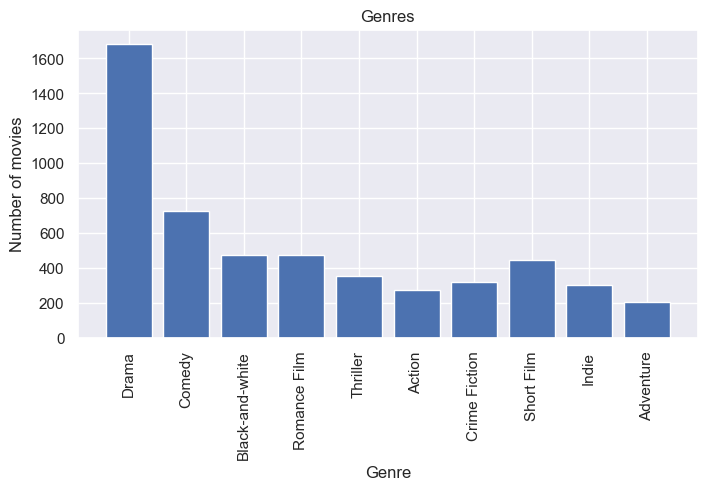

In [163]:
#filter the movies with rating higher than 7 from the movies_main dataset
movies_main_filtered= movies_main[movies_main['averageRating']>=7].copy()
#for each genre in genre_main, find the number of movies in movies_main_filter that have the genre
#and plot the number of movies for each genre
genre_main_filtered = movies_main_filtered['genre'].explode().value_counts()[genre_main.index]
print(genre_main_filtered.shape)
print(genre_main_filtered.index)
plt.figure(figsize=(8, 4))
plt.bar(genre_main_filtered.index, genre_main_filtered.values)
plt.xticks(rotation=90)
plt.title("Genres")
plt.xlabel("Genre")
plt.ylabel("Number of movies")
plt.show()

The graphical representation highlights the prominence of the drama genre, possessing the highest count of highly-rated movies, a figure significantly surpassing other genres. However, it is imperative to consider that the sheer abundance of drama films in the dataset could contribute to this observation. To delve deeper into the matter, we meticulously examine the ratio of high-rated movies to the total number of movies within each genre, providing a more nuanced perspective on the prevalence of quality content within the diverse genres.

/var/folders/xd/632j9v0549bf40k68lrscmkh0000gn/T/ipykernel_64987/1735292041.py:6: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



(10, 2)


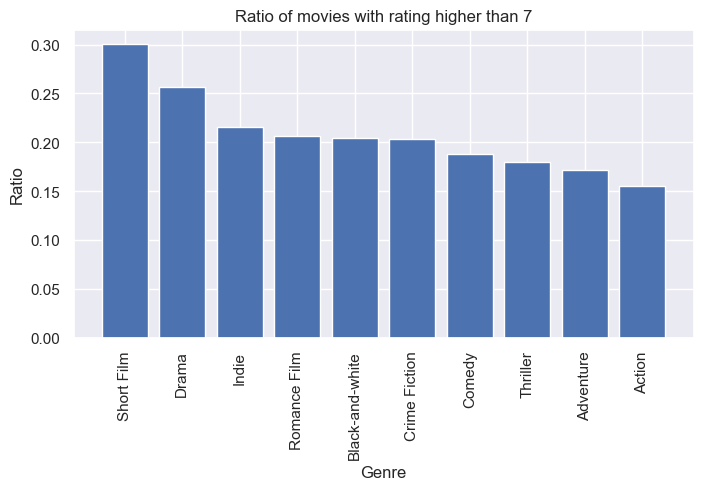

In [164]:
#for each genre, calculate the ratio of movies with rating higher than 7 / total number of movies in that genre
genre_ratio = pd.DataFrame(columns=['genre', 'ratio'])
for g in genre_main.index:
    ratio = len(movies_main_filtered[movies_main_filtered['genre'].apply(lambda x: g in x)]) / len(movies_main[movies_main['genre'].apply(lambda x: g in x)])
    #add the genre and ratio to the dataframe
    genre_ratio = pd.concat([genre_ratio, pd.DataFrame({'genre': [g], 'ratio': [ratio]})], ignore_index=True)#sort the dataframe by ratio
genre_ratio = genre_ratio.sort_values(by='ratio', ascending=False)
print(genre_ratio.shape)
#plot the ratio
plt.figure(figsize=(8, 4))
plt.bar(genre_ratio['genre'], genre_ratio['ratio'])
plt.xticks(rotation=90)
plt.title("Ratio of movies with rating higher than 7")
plt.xlabel("Genre")
plt.ylabel("Ratio")
plt.show()


The graph reveals noteworthy insights into the distribution of highly-rated movies across genres. Notably, short films exhibit the highest ratio of highly-rated movies to the total number of short films, positioning it at the forefront. Drama, despite its prominence in sheer numbers, takes the second position in this ratio analysis. Conversely, adventure and action genres exhibit the lowest ratios, indicating a comparatively lower prevalence of highly-rated movies within these genres. This nuanced examination contributes to a more comprehensive understanding of the quality distribution across various film genres.

Subsequently, we incorporate the temporal variable into our analysis to explore whether certain genres exhibit a notable concentration of highly-rated movies during specific time periods. The objective is to discern if there are temporal intervals wherein a particular genre experiences a significantly higher count of highly-rated movies compared to other periods. This temporal analysis aims to uncover patterns and trends in the distribution of high-quality movies within individual genres across different epochs.

In [165]:
#create a new dataframe with only the top 10 genres and has a rating larger than 7
movies_main = movies[movies["averageRating"] >= 7].copy()
#filter out the movies after 2010 since we are analyzing per decade
movies_main = movies_main[movies_main["year_released"] < 2010].copy()
movies_main = movies_main.reset_index(drop=True)
print(movies_main.shape)
movies_main.head()

(2979, 14)


,wikipedia_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,year_released,tconst,averageRating,numVotes,genre
0,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",1989,tt0097499,7.5,31208.0,"[Costume drama, War film, Epic, Period piece, ..."
1,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",1964,tt0058331,7.8,181829.0,"[Children's/Family, Musical, Fantasy, Comedy, ..."
2,24399617,/m/07s63_7,Bruce Lee: The Lost Interview,1994-11-02,NaN,30.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0d060g"": ""Canada""}","{""/m/02hmvc"": ""Short Film""}",1994,tt0432762,8.6,123.0,[Short Film]
3,8669450,/m/027d9tv,One Six Right,2005-11-25,NaN,73.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0jtdp"": ""Documentary""}",2005,tt0475994,7.9,457.0,[Documentary]
4,164388,/m/015wmt,The Great Santini,1979-10-26,4702575.0,115.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02h8pkk"": ""Family Drama"", ""/m/07s9rl0"": ""...",1979,tt0079239,7.2,6812.0,"[Family Drama, Drama]"


In [166]:
# # plot the number of movies for a genre for each decade
# def plot_decade_genre(genre):
#     # create a new dataframe with only the genre
#     movies_genre = movies_main[movies_main['genre'].apply(lambda x: genre in x)].copy()
#     # create a new column with the decade
#     movies_genre['decade'] = movies_genre['year_released'].apply(lambda x: int(x) // 10 * 10)
#     # create a new dataframe with the number of movies for each decade
#     movies_genre_decade = movies_genre['decade'].value_counts().sort_index()
#     # plot the number of movies for each decade
#     plt.figure(figsize=(8, 4))
#     plt.bar(movies_genre_decade.index, movies_genre_decade.values)
#     plt.title("Number of movies for each decade")
#     plt.xlabel("Decade")
#     plt.ylabel("Number of movies")
#     plt.show()

# # apply the function to the top 10 genres
# interact(plot_decade_genre, genre=genre_main.index,sharey=True)

/var/folders/xd/632j9v0549bf40k68lrscmkh0000gn/T/ipykernel_64987/3447257105.py:24: UserWarning:

The figure layout has changed to tight



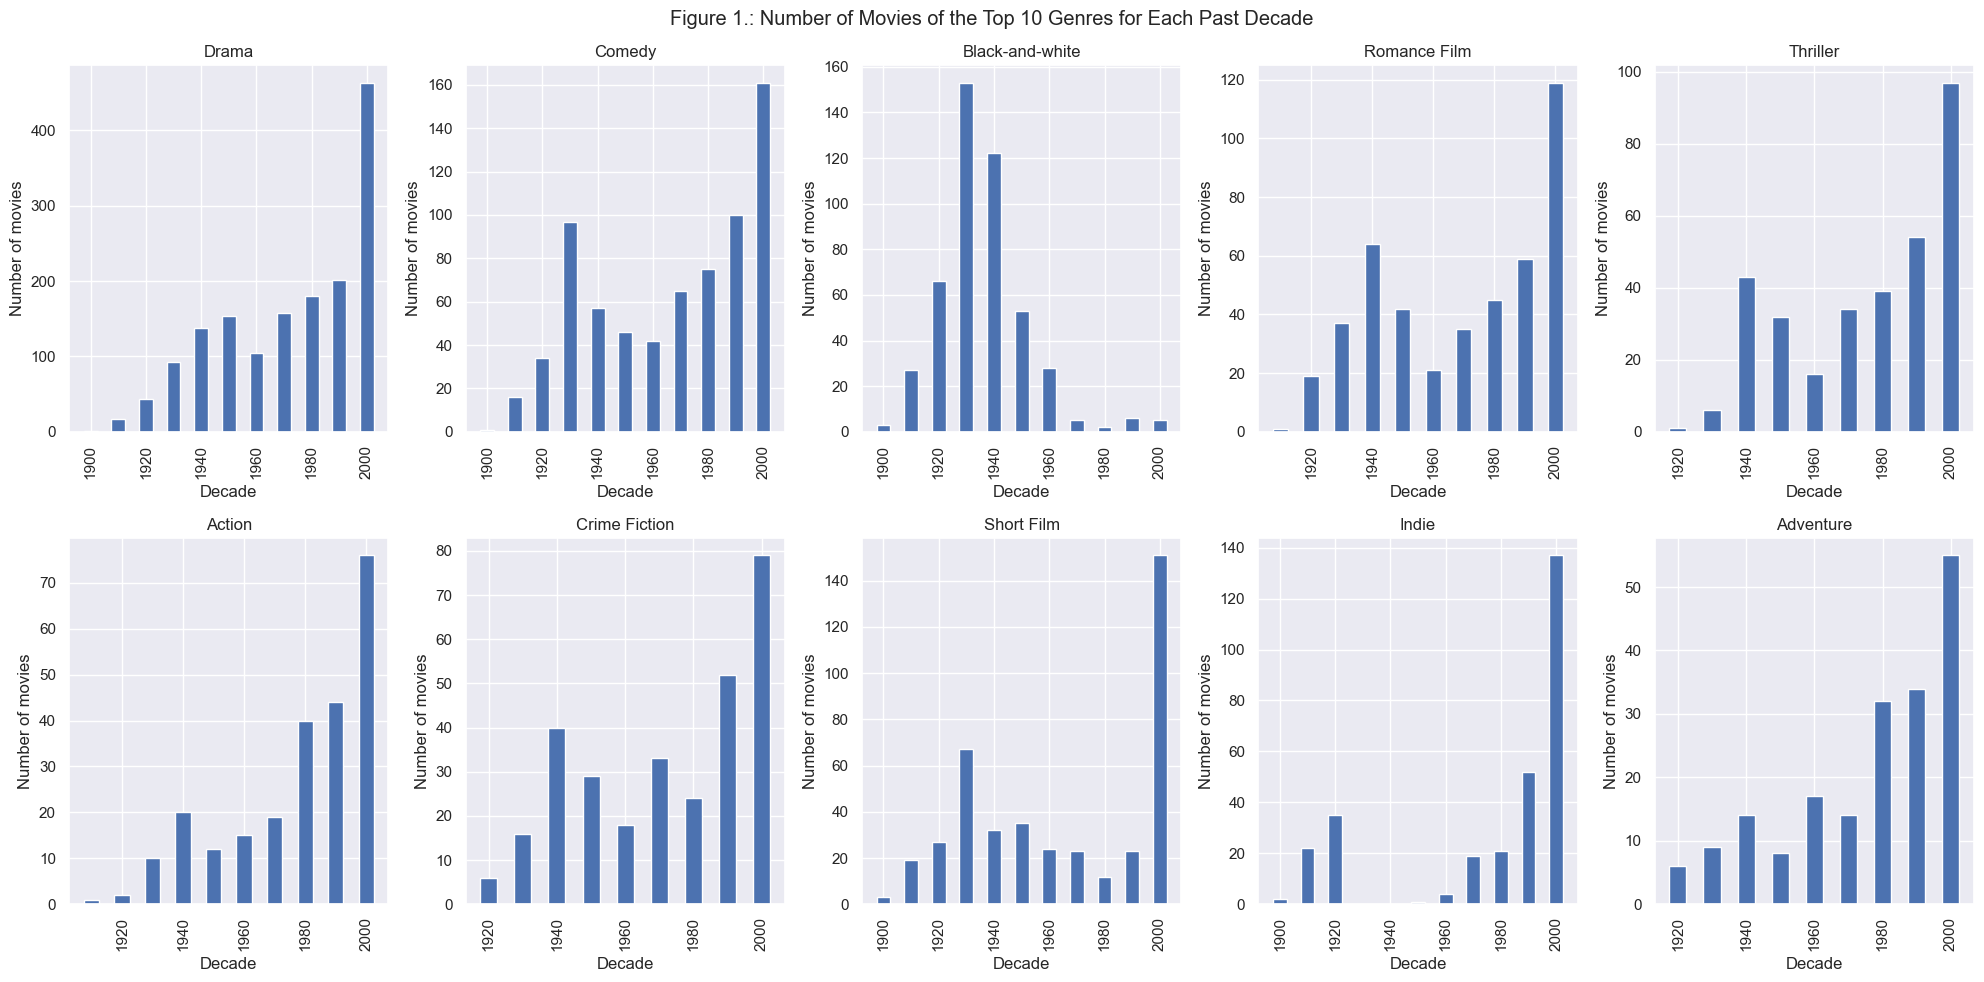

In [167]:
# draw a 2*5 subplot of the number of movies for the first 16 combinations of genres of the top 10 genres in each decade, which are the most frequent combinations
# create a new dataframe with only the top 10 genres
movies_main = movies_main[movies_main['genre'].apply(lambda x: any(item for item in x if item in genre_main.index))].copy() 
# create a new column with the decade
movies_main['decade'] = movies_main['year_released'].apply(lambda x: int(x) // 10 * 10)
# create a new dataframe with the number of movies for each decade
movies_main_decade = movies_main['decade'].value_counts().sort_index()

plt.figure(figsize=(20, 10))
plt.suptitle("Figure 1.: Number of Movies of the Top 10 Genres for Each Past Decade")
# for each genre
for i in range(10):
    # create a new dataframe with only the genre
    movies_genre = movies_main[movies_main['genre'].apply(lambda x: genre_main.index[i] in x)].copy()
    # create a new dataframe with the number of movies for each decade
    movies_genre_decade = movies_genre['decade'].value_counts().sort_index()
    # plot the number of movies for each decade
    plt.subplot(2,5, i + 1)
    plt.bar(movies_genre_decade.index, movies_genre_decade.values,width=5)
    plt.title(genre_main.index[i])
    plt.xlabel("Decade")
    plt.ylabel("Number of movies")
    plt.xticks(rotation=90)
    plt.tight_layout()
# name the plot

plt.show()


In [168]:
# create a new dataframe with only the top 10 genres
movies_main = movies_main[movies_main['genre'].apply(lambda x: any(item for item in x if item in genre_main.index))].copy()
# create a new column with the decade
movies_main['decade'] = movies_main['year_released'].apply(lambda x: int(x) // 10 * 10)
# create a new dataframe with the number of movies for each decade
movies_main_decade = movies_main['decade'].value_counts().sort_index()
# create a new dataframe with the number of movies for each genre and decade
movies_main_decade_genre = pd.DataFrame(columns=['decade', 'genre', 'number'])
# for each decade
for d in movies_main_decade.index:
    # for each genre
    for g in genre_main.index:
        # create a new dataframe with only the genre and decade
        movies_genre_decade = movies_main[(movies_main['genre'].apply(lambda x: g in x)) & (movies_main['decade'] == d)].copy()
        # add the number of movies to the dataframe
        movies_main_decade_genre = pd.concat([movies_main_decade_genre, pd.DataFrame({'decade': [d], 'genre': [g], 'number': [len(movies_genre_decade)]})], ignore_index=True)
# plot the number of movies for each genre and decade
fig = px.bar(movies_main_decade_genre, x="decade", y="number", color="genre", barmode="group",width=1200)
fig.update_layout(title_text="Figure 1.6: Number of Movies of the Top 10 Genres for Each Past Decade")
fig.write_html("1-6.html")
fig.show()

In [169]:
# now we explore the combination of genres
# plot the number of movies for each combination of genres of the top 10 genres in each decade
plt.figure(figsize=(8, 4))
def plot_genre_combination_decade(genre1, genre2):
    # create a new dataframe with only the two genres
    movies_genre = movies_main[movies_main['genre'].apply(lambda x: genre1 in x and genre2 in x)].copy()
    # create a new column with the decade
    movies_genre['decade'] = movies_genre['year_released'].apply(lambda x: int(x) // 10 * 10)
    # create a new dataframe with the number of movies for each decade
    movies_genre_decade = movies_genre['decade'].value_counts().sort_index()
    # plot the number of movies for each decade

    plt.bar(movies_genre_decade.index, movies_genre_decade.values,width=5)
    plt.title("Number of movies for each decade of genre")
    plt.xlabel("Decade")
    plt.ylabel("Number of movies")
    plt.show()


# apply the function to the top 10 genres
#interact(plot_genre_combination_decade, genre1=genre_main.index, genre2=genre_main.index)

<Figure size 800x400 with 0 Axes>

/var/folders/xd/632j9v0549bf40k68lrscmkh0000gn/T/ipykernel_64987/91920691.py:17: UserWarning:

The figure layout has changed to tight



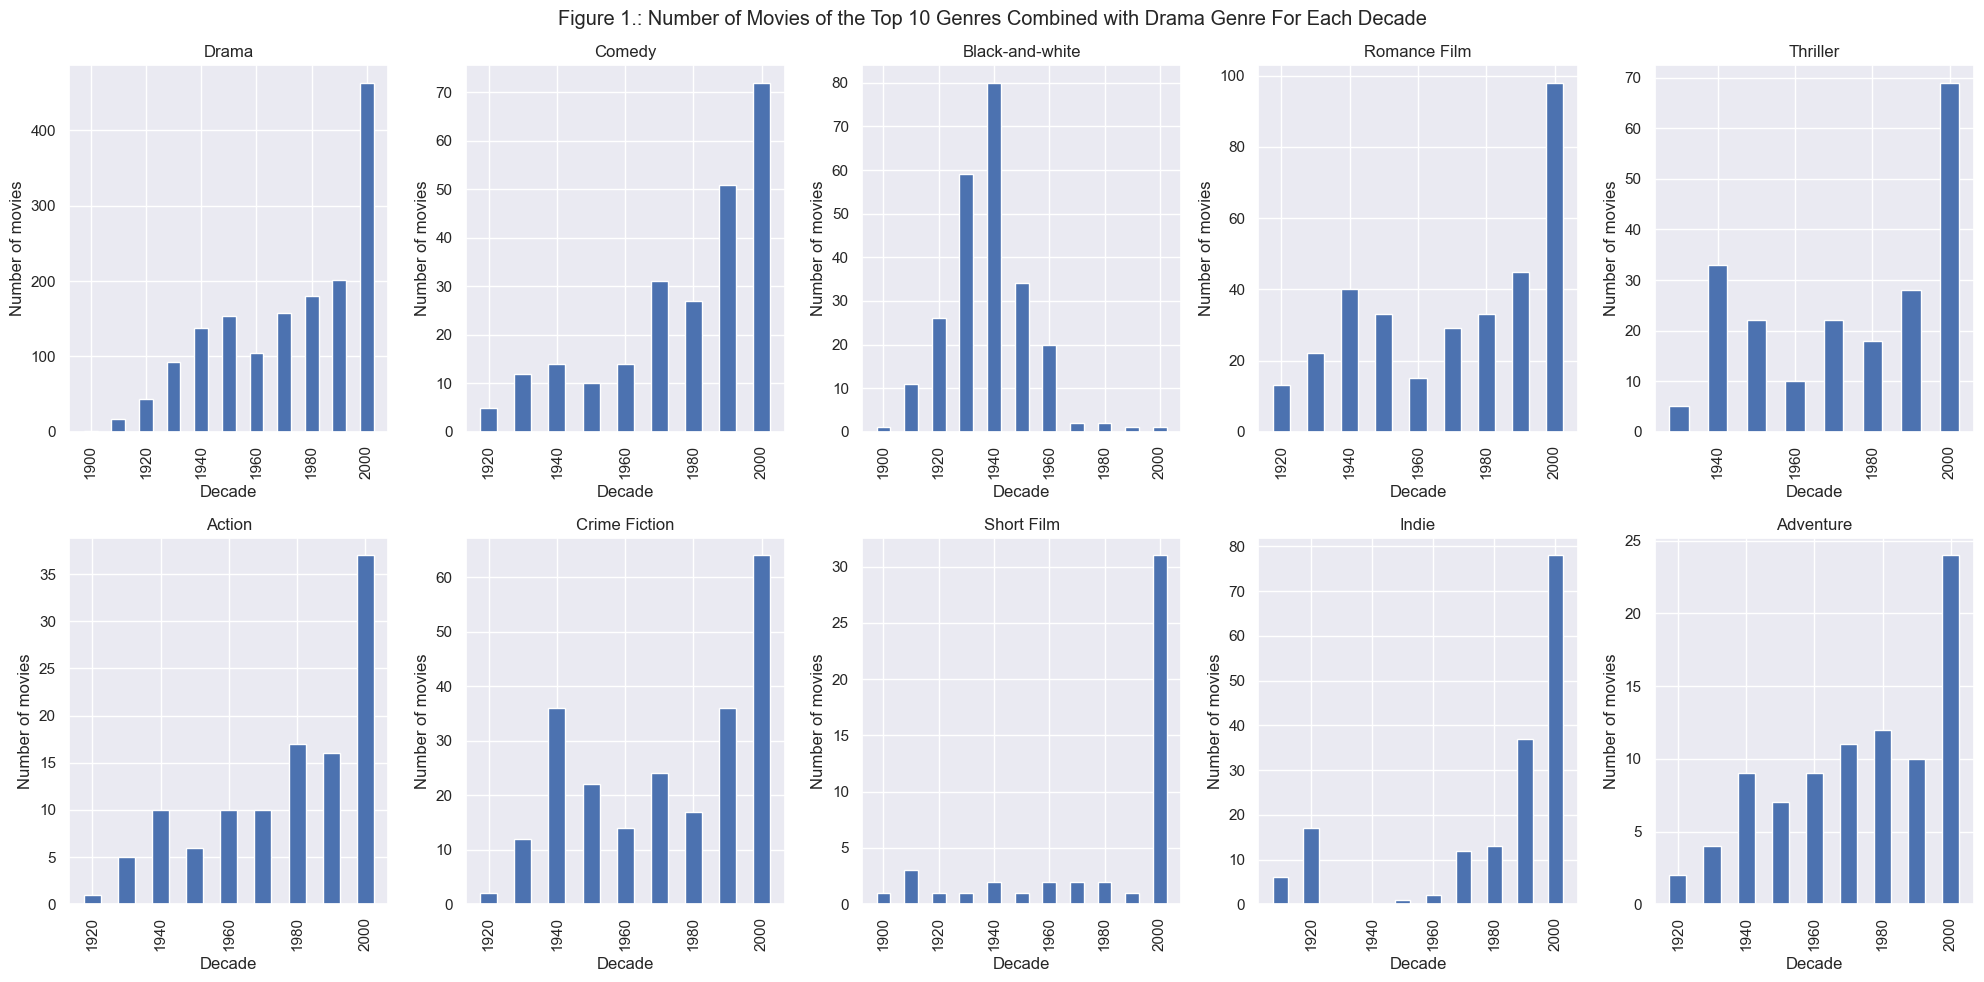

In [170]:
# draw a 2*5 subplot of the number of movies for the movies that are both drama and other genres in each decade
plt.figure(figsize=(20, 10))
plt.suptitle("Figure 1.: Number of Movies of the Top 10 Genres Combined with Drama Genre For Each Decade")
# for each genre
for i in range(10):
    # create a new dataframe with only the genre
    movies_genre = movies_main[movies_main['genre'].apply(lambda x: genre_main.index[i] in x and "Drama" in x)].copy()
    # create a new dataframe with the number of movies for each decade
    movies_genre_decade = movies_genre['decade'].value_counts().sort_index()
    # plot the number of movies for each decade
    plt.subplot(2,5, i + 1)
    plt.bar(movies_genre_decade.index, movies_genre_decade.values,width=5)
    plt.title(genre_main.index[i])
    plt.xlabel("Decade")
    plt.ylabel("Number of movies")
    plt.xticks(rotation=90)
    plt.tight_layout()
# add a name for the entire figure

plt.show()


In [171]:
# use plotly to plot the above plot except for Drama and Drama genre
# create a new dataframe with only the top 10 genres
movies_main = movies_main[movies_main['genre'].apply(lambda x: any(item for item in x if item in genre_main.index) and 'Drama' in x)].copy()
# create a new column with the decade
movies_main['decade'] = movies_main['year_released'].apply(lambda x: int(x) // 10 * 10)
# create a new dataframe with the number of movies for each decade
movies_main_decade = movies_main['decade'].value_counts().sort_index()
# create a new dataframe with the number of movies for each genre and decade
movies_main_decade_genre = pd.DataFrame(columns=['decade', 'genre', 'number'])
# for each decade
for d in movies_main_decade.index:
    # for each genre
    for g in genre_main.index:
        if(g=='Drama'):
            continue
        # create a new dataframe with only the genre and decade
        movies_genre_decade = movies_main[(movies_main['genre'].apply(lambda x: g in x)) & (movies_main['decade'] == d)].copy()
        # add the number of movies to the dataframe
        movies_main_decade_genre = pd.concat([movies_main_decade_genre, pd.DataFrame({'decade': [d], 'genre': [g], 'number': [len(movies_genre_decade)]})], ignore_index=True)
# plot the number of movies for each genre and decade
fig = px.bar(movies_main_decade_genre, x="decade", y="number", color="genre", barmode="group",width=1200)
fig.update_layout(title_text="Figure 1.7:  Number of Movies of the Top 10 Genres Combined with Drama Genre For Each Decade")
fig.write_html("1-7.html")
fig.show()

In [172]:
# replot the above plot using plotly to generate an interactive plot to html
import plotly.express as px
def plot_genre_combination_decade_plotly(genre1, genre2):
    # create a new dataframe with only the two genres
    movies_genre = movies_main[movies_main['genre'].apply(lambda x: genre1 in x and genre2 in x)].copy()
    # create a new column with the decade
    movies_genre['decade'] = movies_genre['year_released'].apply(lambda x: int(x) // 10 * 10)
    # create a new dataframe with the number of movies for each decade
    movies_genre_decade = movies_genre['decade'].value_counts().sort_index()
    # plot the number of movies for each decade
    fig = px.bar(movies_genre_decade, x=movies_genre_decade.index, y=movies_genre_decade.values, labels={'x':'Decade', 'y':'Number of movies'})
    fig.update_layout(title="Number of movies for each decade of genre")
    fig.show()
    fig.write_html("plot1.html")

# apply the function to the top 10 genres
#interact(plot_genre_combination_decade, genre1=genre_main.index, genre2=genre_main.index)

The graphical representation highlights two notable surges in the number of highly-rated movies throughout history: one during the 1930s and another in the 2000s.  During these intervals, there is a pronounced surge in the number of movies receiving high ratings. Intriguingly, in the aftermath of both periods, there is a noticeable decline, coinciding with two significant economic crises—the Great Depression in the 1930s and the global financial crisis of 2008. The observed correlation between economic downturns and fluctuations in the production and reception of high-quality movies prompts an exploration into the intricate dynamics at play during times of economic instability. Unraveling the contextual factors influencing these trends can provide valuable insights into the evolving landscape of the film industry across different historical epochs.

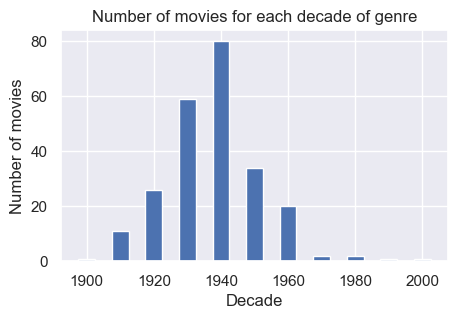

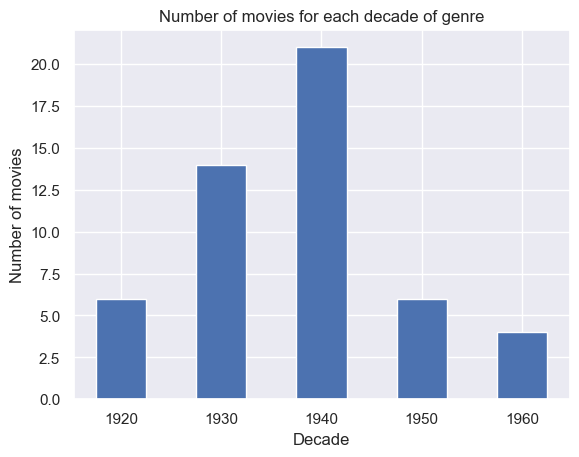

In [173]:
plt.figure(figsize=(5,3))
plot_genre_combination_decade('Drama', 'Black-and-white')
plot_genre_combination_decade('Romance Film', 'Black-and-white')

It comes as no surprise that a significant proportion of highly-rated movies are in black-and-white, with a notable concentration within the drama genre. This observation underscores the enduring appeal of the black-and-white aesthetic in conveying the nuanced themes often associated with dramatic narratives. Furthermore, within the realm of black-and-white films, the comedy and romance genres emerge as particularly prominent, constituting the majority of high-rated movies. This alignment suggests a unique intersection of visual style and storytelling elements that contribute to the success and acclaim of black-and-white comedies and romances. A more in-depth exploration of these specific films can shed light on the distinctive qualities that make them stand out within the broader landscape of high-quality cinema.

Delving into the significant surge observed in the 2000s, we aim to meticulously examine the intricate effects resulting from combinations of genres during this prolific period. By scrutinizing the interplay between different genres within this temporal frame, we seek to unravel patterns, preferences, and potential synergies that contributed to the remarkable increase in the number of highly-rated movies. This focused analysis on genre combinations promises to unveil insights into the evolving tastes, creative trends, and collaborative dynamics that defined the cinematic landscape during this particular era, enriching our understanding of the multifaceted factors influencing the success of movies.

In [174]:
# now lets focus on the years after 2000
# create a new dataframe with only the movies after 2000
movies_2000 = movies_main[(movies_main['year_released'] >= 2000)].copy()
# do the above analysis for every year in the decade
def plot_genre_combination_year(genre1,genre2):
    # create a new dataframe with only the two genres
    movies_genre = movies_2000[movies_2000['genre'].apply(lambda x: genre1 in x and genre2 in x)].copy()
    # create a new dataframe with the number of movies for each year
    movies_genre_year = movies_genre['year_released'].value_counts().sort_index()
    # plot the number of movies for each decade
    plt.figure(figsize=(8, 4))
    plt.bar(movies_genre_year.index, movies_genre_year.values,width=1)
    plt.title("Number of movies for each year after 2000")
    plt.xlabel("Decade")
    plt.ylabel("Number of movies")
    plt.show()

# apply the function to the top 10 genres
interact(plot_genre_combination_year, genre1=genre_main.index, genre2=genre_main.index)

interactive(children=(Dropdown(description='genre1', options=('Drama', 'Comedy', 'Black-and-white', 'Romance F…

<function __main__.plot_genre_combination_year(genre1, genre2)>

In [175]:
# draw a px plot of the number of movies for the movies that are both drama and other genres in each year after 2000
# create a new dataframe with only the top 10 genres
movies_2000 = movies_2000[movies_2000['genre'].apply(lambda x: any(item for item in x if item in genre_main.index) and 'Drama' in x)].copy()
# create a new dataframe with the number of movies for each year
movies_2000_year = movies_2000['year_released'].value_counts().sort_index()
# create a new dataframe with the number of movies for each genre and year
movies_2000_year_genre = pd.DataFrame(columns=['year', 'genre', 'number'])
# for each year
for y in movies_2000_year.index:
    # for each genre
    for g in genre_main.index:
        if(g=='Drama'):
            continue
        # create a new dataframe with only the genre and year
        movies_genre_year = movies_2000[(movies_2000['genre'].apply(lambda x: g in x)) & (movies_2000['year_released'] == y)].copy()
        # add the number of movies to the dataframe
        movies_2000_year_genre = pd.concat([movies_2000_year_genre, pd.DataFrame({'year': [y], 'genre': [g], 'number': [len(movies_genre_year)]})], ignore_index=True)
# plot the number of movies for each genre and year
fig = px.bar(movies_2000_year_genre, x="year", y="number", color="genre", barmode="group",width=1200)
fig.update_layout(title_text="Figure 1.10: Number of Movies of the Top 10 Genres Combined with Drama Genre For Each Year After 2000")
fig.write_html("1-10.html")
fig.show()


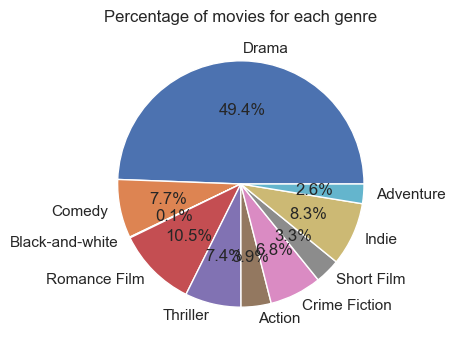

In [176]:
#plot a pie chart for the top 10 genres in the decade 2000-2010 which shows the percentage of the number of movies for each genre in genre_main
movie_genre=movies_2000['genre'].explode().value_counts()[genre_main.index]
plt.figure(figsize=(8, 4))
plt.pie(movie_genre.values, labels=movie_genre.index, autopct='%1.1f%%')
plt.title("Percentage of movies for each genre")
plt.show()

From the comprehensive analysis presented above, a discernible trend emerges, indicating that the drama genre has consistently dominated the cinematic landscape. This dominance is reflected in both the largest number of total movies across all genres. The enduring popularity and prevalence of drama underscore its universal appeal, serving as a versatile and enduring vehicle for storytelling that resonates with diverse audiences. As we continue to explore the intricacies of genre dynamics, the prominence of drama stands as a testament to its enduring significance within the ever-evolving world of cinema.

### DURATION

The duration of a movie, a fundamental element in cinematic storytelling, serves as a crucial factor influencing the overall viewing experience and perceived quality. Film durations vary widely, ranging from concise short films to sprawling epics. The impact of a movie's duration on its quality is a nuanced consideration that intertwines with storytelling techniques, pacing, audience engagement, and thematic depth. A well-crafted film can leverage its duration to immerse viewers in its narrative world, allowing for character development, plot intricacies, and emotional resonance. However, an excessively long or brief duration may pose challenges, potentially leading to pacing issues or insufficient exploration of complex themes. This intricate interplay between movie duration and quality underscores the significance of understanding how filmmakers navigate the temporal dimension to create compelling and impactful cinematic experiences.

In [177]:
#duration
#the distribution of runtime and its correlation with rating
print(movies[["movie_runtime", "averageRating"]].count())
duration = movies[["movie_runtime", "averageRating"]].dropna()
duration.count()

movie_runtime    13609
averageRating    14369
dtype: int64


movie_runtime    13609
averageRating    13609
dtype: int64

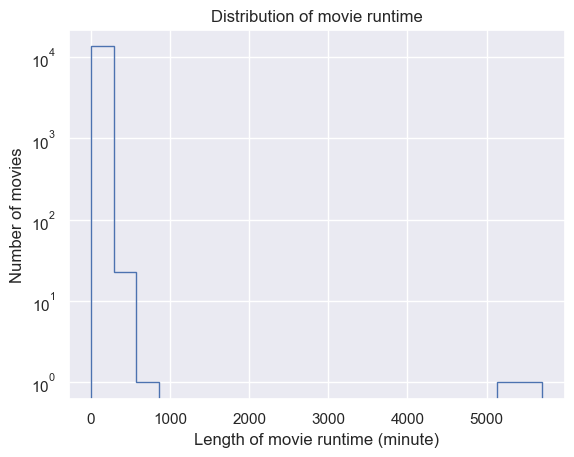

In [178]:
# histogram plot without removing outliers
plt.hist(duration["movie_runtime"], histtype="step", log=True, bins=20)
plt.title("Distribution of movie runtime")
plt.xlabel("Length of movie runtime (minute)")
plt.ylabel("Number of movies")
plt.show()


Upon examination of the graph presented above, a noteworthy pattern emerges where a considerable number of films exhibit either exceptionally short or excessively long durations, exceeding 5000 minutes. To ensure the precision and reliability of our analysis, it is imperative to address these outliers. Eliminating such extreme values is essential for a more accurate representation of the dataset and will contribute to the robustness of our findings.

Additionally, it is pertinent to acknowledge that short films often have relatively brief durations, which could potentially skew our analysis of runtime for regular feature-length movies. Fortunately, a substantial portion of these short films falls within the category of outliers slated for removal. This strategic refinement of the dataset aims to enhance the integrity of our examination of movie durations and facilitate a more nuanced understanding of the temporal aspects within the cinematic landscape.

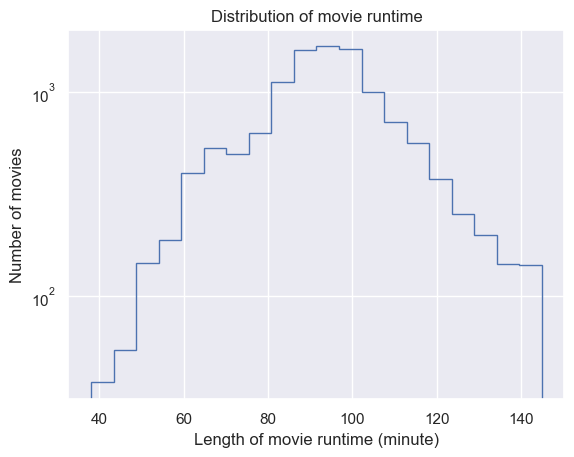

In [179]:
# histogram plot with removing outliers using IQR
q1 = duration["movie_runtime"].quantile(0.25)
q3 = duration["movie_runtime"].quantile(0.75)
iqr = q3 - q1
duration = duration[duration["movie_runtime"] < q3 + 1.5 * iqr]
duration = duration[duration["movie_runtime"] > q1 - 1.5 * iqr]

plt.hist(duration["movie_runtime"], histtype="step", log=True, bins=20)
plt.title("Distribution of movie runtime")
plt.xlabel("Length of movie runtime (minute)")
plt.ylabel("Number of movies")
plt.show()


/Users/zhouyanling/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/zhouyanling/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/zhouyanling/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/zhouyanling/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/zhouyanling/opt/anaconda3/envs/ada/lib/py

Text(0.5, 0.98, 'Figure 2.3: Correlation between Movie Runtime and Rating')

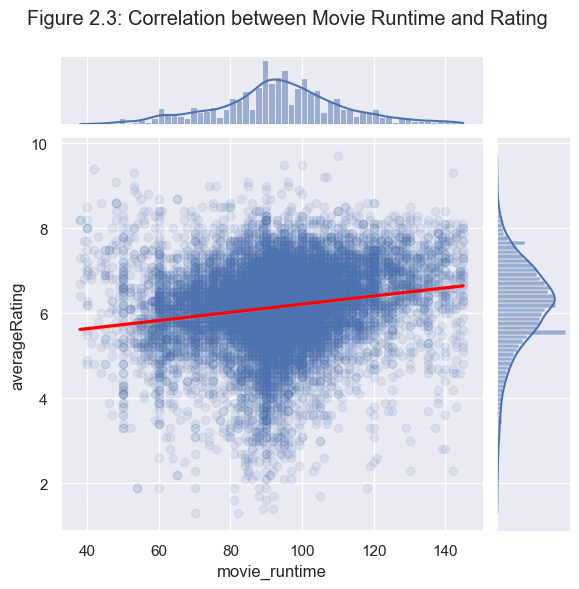

In [180]:
# use sns to plot the scatter plot of runtime and rating with regression line
sns.jointplot(x="movie_runtime", y="averageRating", data=duration, kind="reg", scatter_kws={"alpha": 0.1}, line_kws={"color": "red"})
# set the title
plt.subplots_adjust(top=0.9)
plt.suptitle("Figure 2.3: Correlation between Movie Runtime and Rating")

In [181]:
# plot the above plot using plotly to generate an interactive plot to html
# with the regression line colored red
fig = px.scatter(duration, x="movie_runtime", y="averageRating", trendline="ols", trendline_color_override="red")
fig.update_layout(title="Figure 2.3: Correlation between Movie Runtime and Rating")
fig.write_html("2-3.html")
fig.show()

The preliminary regression analysis indicates a noteworthy trend where longer durations tend to correlate with higher average ratings. This initial observation prompts further investigation to validate and refine our understanding of the relationship between movie duration and audience ratings. While this finding suggests a positive association, additional factors such as genre, thematic content, and storytelling techniques may contribute to a more nuanced interpretation. Therefore, a more in-depth and comprehensive analysis is warranted to ensure a robust understanding of the intricate dynamics influencing movie ratings in relation to their durations.

In [182]:
#perform linear regression on duration data, and plot the regression line
model=smf.ols(formula='averageRating ~ movie_runtime', data=duration)
results=model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     374.7
Date:                Wed, 20 Dec 2023   Prob (F-statistic):           3.26e-82
Time:                        17:31:31   Log-Likelihood:                -16873.
No. Observations:               11874   AIC:                         3.375e+04
Df Residuals:                   11872   BIC:                         3.376e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         5.2557      0.047    110.670

Our analysis adopts a dual perspective, delineated by two distinct criteria. Firstly, the dataset is bifurcated based on ratings, with a division into two halves. Subsequently, the dataset is segregated based on duration, categorizing movies with a runtime exceeding 80 minutes as long-duration films. Two sets of t-tests are conducted to discern potential statistically significant differences: one examines the mean average duration between high-rating and lower-rating movies, while the other investigates the mean average rating between long-duration and shorter-duration movies. These parallel analyses offer a comprehensive exploration of the interplay between movie ratings, durations, and their potential impact on cinematic characteristics.

In [183]:
#filter the movies with rating higher than 7 from the movies_main dataset
movies_high_rating= duration[duration['averageRating']>=7].copy()
movies_non_high_rating= duration[duration['averageRating']<7].copy()
print(movies_high_rating.shape)
print(movies_non_high_rating.shape)


(2459, 2)
(9415, 2)


Conducting a t-test on the runtime variable is imperative to ascertain the presence of a statistically significant distinction between two subsets of movies based on their ratings. Specifically, this analysis aims to discern whether there exists a noteworthy difference in runtime duration between movies with ratings exceeding 7 and those with ratings below 7. By rigorously applying statistical methods, we endeavor to illuminate any discernible patterns or variations in movie runtimes associated with differing rating categories.

In [184]:
#perform a t-test on the runtime of movies with rating higher than 7 and movies with rating lower than 7 to see if there is a significant difference
stats.ttest_ind(a=movies_high_rating["movie_runtime"], b=movies_non_high_rating["movie_runtime"],equal_var=False)

TtestResult(statistic=15.615541110148706, pvalue=3.6823789974589413e-53, df=3435.0436677777066)

In [185]:
#calculate the mean of runtime for movies with rating higher than 7 and movies with rating lower than 7 and their difference
print(movies_high_rating["movie_runtime"].mean())
print(movies_non_high_rating["movie_runtime"].mean())
diff=movies_high_rating["movie_runtime"].mean()-movies_non_high_rating["movie_runtime"].mean()
print(f"The mean difference in duration is:{diff}")

#calculate the percentage of difference
perc=diff/movies_non_high_rating["movie_runtime"].mean()*100
print(f"The percentage difference in duration is:{perc}")

99.47417649450996
92.34965480616039
The mean difference in duration is:7.124521688349574
The percentage difference in duration is:7.714724763512941


In [186]:
# visualize the t-test result using plotly
fig = px.histogram(duration, x="movie_runtime", color="averageRating", marginal="box", barmode="overlay",nbins=20)
fig.update_layout(title_text="Figure 2.4: Distribution of Movie Runtime")
fig.write_html("2-4.html")
fig.show()

Based on the preceding analysis, it is evident that a statistically significant difference exists between the means of movie runtimes for those with ratings exceeding 7 and those with ratings below 7. The mean duration of high-rating movies is found to be 7.71% higher than that of their lower-rated counterparts. This finding suggests a notable variation in runtime characteristics between movies of distinct rating categories, emphasizing the potential influence of audience ratings on the temporal aspects of cinematic storytelling.

In [187]:
#split the movies into two groups, one with movie_runtime>=80 and the other with movie_runtime<80
movies_long_duration=duration[duration["movie_runtime"]>=80]
movies_short_duration=duration[duration["movie_runtime"]<80]

In [188]:
#perform a t-test on the rating of movies with runtime>=80 and movies with runtime<80 to see if there is a significant difference
stats.ttest_ind(a=movies_long_duration["averageRating"], b=movies_short_duration["averageRating"],equal_var=False)

TtestResult(statistic=6.304250491709349, pvalue=3.2633531397026146e-10, df=3444.252730345831)

In [189]:
#calculate the mean of rating for movies with runtime>=80 and movies with runtime<80 and their difference
print(movies_long_duration["averageRating"].mean())
print(movies_short_duration["averageRating"].mean())
diff=movies_long_duration["averageRating"].mean()-movies_short_duration["averageRating"].mean()
print(f"The mean difference in rating is:{diff}")

#calculate the percentage of difference
perc=diff/movies_short_duration["averageRating"].mean()*100
print(f"The percentage difference in rating is:{perc}")


6.185743995008838
6.037749224634471
The mean difference in rating is:0.1479947703743676
The percentage difference in rating is:2.451157954201506


In [190]:
# visualize the t-test result using plotly
fig = px.histogram(duration, x="averageRating", color="movie_runtime", marginal="box", barmode="overlay",nbins=20)
fig.update_layout(title_text="Figure 2.5: Distribution of Movie Rating")
fig.write_html("2-5.html")
fig.show()


Based on the outcomes presented above, it is evident that a statistically significant difference exists in the means of average ratings between long-duration movies and shorter-duration movies. Specifically, long-duration movies exhibit a higher mean rating of 6.19, contrasting with the mean rating of 6.03 observed for shorter-duration movies. This finding underscores a notable association between the temporal extent of movies and audience ratings, suggesting that longer-duration films tend to garner higher average ratings compared to their shorter-duration counterparts.

### TOPIC DETECTION